# NYC Taxi: Знакомство с данными и агрегация

Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с
 - нулевой длительностью
 - нулевым количеством пассажиров
 - нулевым расстоянием поездки по счётчику
 - координатами начала, не попадающими в прямоугольник Нью-Йорка
 
 Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

7. Загрузите ноутбук в форму ниже

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Загрузка данных за май 2016

In [3]:
%%time
data = pd.read_csv('data\yellow_tripdata_2016-05.csv', header=0, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

Wall time: 49.7 s


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(12), int64(4), object(1)
memory usage: 1.7+ GB


In [7]:
%%time
# преобразуем некоторые типы (уменьшает dataframe на 300 Mb)
data = data.astype({'VendorID': 'int8', 'passenger_count': 'int8', 'RatecodeID': 'int8', 'payment_type': 'int8'}) 

Wall time: 1.34 s


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
VendorID                 int8
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int8
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int8
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int8
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(12), int8(4), object(1)
memory usage: 1.4+ GB


In [9]:
"""
на будущее заметим:
VendorID, RatecodeID, payment_type - категориальные переменные
store_and_fwd_flag - бинарная
"""
data.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76
5,2,2016-05-01,2016-05-01 00:05:19,2,0.63,-73.979294,40.755764,1,N,-73.988014,40.758469,1,5.0,0.5,0.5,0.00,0.0,0.3,6.30
6,2,2016-05-01,2016-05-01 00:15:43,1,6.68,-73.981544,40.780739,1,N,-73.937805,40.855343,1,20.5,0.5,0.5,2.00,0.0,0.3,23.80
7,2,2016-05-01,2016-05-01 00:06:31,1,1.48,-73.987198,40.750507,1,N,-73.980797,40.767826,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96
8,2,2016-05-01,2016-05-01 00:00:00,4,1.59,-74.001610,40.740990,1,N,-73.981079,40.730675,1,8.0,0.5,0.5,0.00,0.0,0.3,9.30
9,2,2016-05-01,2016-05-01 00:00:00,3,3.52,-74.013855,40.714119,1,N,-73.994049,40.761452,2,13.0,0.5,0.5,0.00,0.0,0.3,14.30


## 2. Очистка данных

In [10]:
# границы мегаполиса
WEST_POINT = -74.25559
EAST_POINT = -73.70001
SOUTH_POINT = 40.49612
NORTH_POINT = 40.91553

In [11]:
# эта процедура исключает из таблицы различные нулевые данные, как требует задание
def cleaning_data(df):
    
    # удаляем поездки с нулевой длительностью
    df.drop(list(df.index[(data.tpep_dropoff_datetime - data.tpep_pickup_datetime) == '00:00:00']), inplace=True)
    
    # удаляем поездки с нулевым количеством пассажиров
    df.drop(list(df.index[data.passenger_count == 0]), inplace=True)
    
    # удаляем поездки с нулевым расстоянием по счетчику
    df.drop(list(df.index[data.trip_distance == 0]), inplace=True)
    
    # удаляем поездки с координатами начала, не попадающими в прямоугольник Нью-Йорка
    df.drop(list(df.index[(df.pickup_longitude < WEST_POINT) | (df.pickup_longitude > EAST_POINT) |
                          (df.pickup_latitude < SOUTH_POINT) | (df.pickup_latitude > NORTH_POINT)])
            , inplace=True)
    
    return df

In [12]:
# эта процедура отсекает минуты и секунды у времени начала и окончания
# после запуска этой процедуры не пытайтесь запустить cleaning_data
# т.к. исчезнут все поездки которые происходили внутри часа )
def round_time(df):
    
    df.tpep_pickup_datetime = df.tpep_pickup_datetime.dt.floor(freq='h')
    df.tpep_dropoff_datetime = df.tpep_dropoff_datetime.dt.floor(freq='h')
    
    return df

In [13]:
%%time
cleaning_data(data).info() # сколько осталось после очистки?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11626521 entries, 0 to 11836841
Data columns (total 19 columns):
VendorID                 int8
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int8
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int8
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int8
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(12), int8(4), object(1)
memory usage: 1.4+ GB
Wall time: 8.75 s


In [14]:
%%time
round_time(data)[:5]

Wall time: 847 ms


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


## 3. Агрегирование данных

In [15]:
# разобьем оси на 50 равных отрезков
x = np.linspace(WEST_POINT, EAST_POINT, 51)
y = np.linspace(SOUTH_POINT, NORTH_POINT, 51)

In [16]:
%%time
# для всех периодов, которые встречаются в data, запускаем binned_statistic_2d
# работает около минуты, поэтому использовал tdqm, чтоб следить за процессом
# если tdqm не установелен, не беда
res=[]
periods = data.tpep_pickup_datetime.unique()

try:
    from tqdm import tqdm_notebook # резинка, чтоб не скучно было ждать

except ModuleNotFoundError: # если tqdm не утановлен
    for i in range(len(periods)):
        time_samp = data[data.tpep_pickup_datetime == periods[i]]
        ret = stats.binned_statistic_2d(time_samp.pickup_longitude, time_samp.pickup_latitude, 
                                        None, statistic='count', bins=[x, y])
        res = res + (list(np.array([list([periods[i]])*2500, 
                                    range(1,2501), 
                                    ret.statistic.ravel()
                                   ]).T))
else:
    for i in tqdm_notebook(range(len(periods))):
        time_samp = data[data.tpep_pickup_datetime == periods[i]]
        ret = stats.binned_statistic_2d(time_samp.pickup_longitude, time_samp.pickup_latitude, 
                                        None, statistic='count', bins=[x, y])
        res = res + (list(np.array([list([periods[i]])*2500, 
                                    range(1,2501), 
                                    ret.statistic.ravel()
                                   ]).T))
res = pd.DataFrame(res, columns = ['date', 'bins', 'numb'])
res = res.astype({'bins': 'int16', 'numb':'int16'}) # размер в памяти уменьшается в два раза

A Jupyter Widget


Wall time: 50.7 s


In [17]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860000 entries, 0 to 1859999
Data columns (total 3 columns):
date    datetime64[ns]
bins    int16
numb    int16
dtypes: datetime64[ns](1), int16(2)
memory usage: 21.3 MB


## 4. Вывод данных

In [18]:
res.head(10)

,date,bins,numb
0,2016-05-01,1,0
1,2016-05-01,2,0
2,2016-05-01,3,0
3,2016-05-01,4,0
4,2016-05-01,5,0
5,2016-05-01,6,0
6,2016-05-01,7,0
7,2016-05-01,8,0
8,2016-05-01,9,0
9,2016-05-01,10,0


In [19]:
# убедимся, что все поездки попали в итоговую таблицу
res.numb.sum() == len(data)

True

## 5. Empire State Building

In [20]:
# Google maps утверждает, что координаты Empire State Building: 40.747780, -73.985830
ESB_LONGITUDE = -73.985830
ESB_LATITUDE = 40.747780

In [21]:
# уточним номер ячейки
# Алгоритм:
#  из границ ячеек вычитаем координаты искомой точки; наша ячейка на переходе от минуса к плюсу
#  берем количество отрицательных значений, что дает нам координату в матрице
#  количество строк до найденой (n-1) умножаем на длину строки - 50, добавляем номер столбца

def cell_numb(longitude, latitude, x, y):
    n = list(x - longitude < 0).count(True)
    m = list(y - latitude < 0).count(True)
    return (n - 1) * 50 + m

esb_cell = cell_numb(ESB_LONGITUDE, ESB_LATITUDE, x, y)
    
print('номер ячейки - ', esb_cell)

номер ячейки -  1231


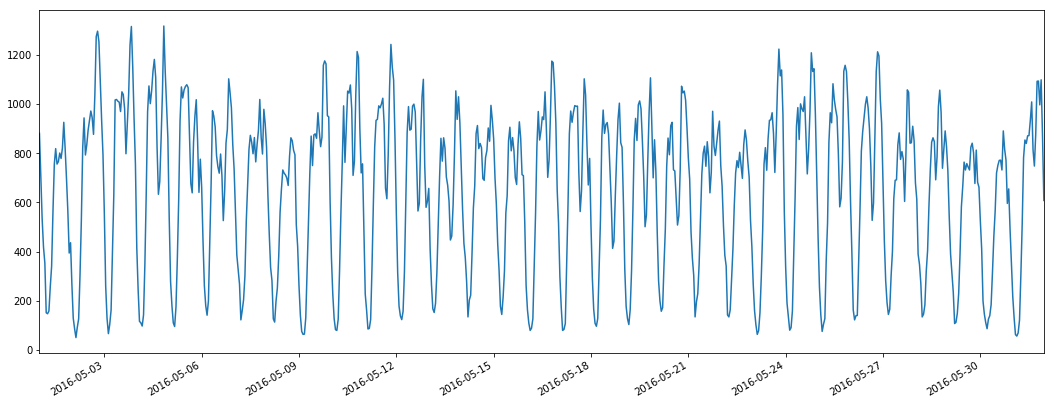

In [22]:
# на графике видна суточная и недельная сезонность
plt.figure(figsize(18,7))
pd.Series(list(res.numb[res.bins == esb_cell]), index = list(res.date[res.bins == esb_cell])).plot()

## 6. Нулевые комбинации час-ячейка

In [23]:
print('количество пар час-ячейка, для которых не было совершено ни одной поездки - {0:,}'.format(len(res[res.numb == 0])))

количество пар час-ячейка, для которых не было совершено ни одной поездки - 1,718,238
